In [1]:
# SQLITE PATH
path = 'test_ml.sqlite'

In [58]:
#### EMPTY LISTS TO STORE DATA 
############################### NOTE - has not to be run everytime as it resets the previously extracted list
main_list = []
raw_RMS = []
main_list_full = []
raw_RMS_full = []

class_codes = []
pos_codes = []
phase_codes  = []
ground_codes = []
filenames = []
waveform_ids = []
ground_code_ids = []
frequencies = []

In [69]:
import sqlite3
import pandas as pd
import numpy as np
import time
import shutil
from PIL import Image
from enum import IntEnum

event_dict = {
    'GENERIC_ARCING': 23100, 
    'GENERIC_LONG_ARCING': 23104,
    'GENERIC_SHORT_ARCING': 23102,
    'CAPACITOR_ON': 10110,
    'CAPACITOR_OFF': 10120,
    'CAPACITOR_ON_ABNORMAL': 20110,
    'CAPACITOR_RESTRIKE': 20210,
    'CAPACITOR_RESTRIKE_SEVERE': 20211,
    'CAPACITOR_ON_UNBALANCED': 20130,
    'CAPACITOR_BOUNCE': 20310,
    'CAPACITOR_OFF_UNBALANCED': 20140,
    'CAPACITOR_ON_VAR_IMBALANCE': 20510,
    'CAPACITOR_OFF_VAR_IMBALANCE': 20520,
    'ARCING_INSIDE_CAPACITOR': 23180,
    'UNKNOWN_ABNORMAL': 28110,
    'CT_PT_SWITCH_CLOSED': 30200,
    'CT_PT_SWITCH_OPENED': 30100,
    'OC_NORMAL': 15110,
    'OC_CAPACITOR': 20410,
    'OC_LESS_THAN_1_CYC': 15220,
    'REVERSE_FAULT': 15710,
    'INRUSH': 13170,
    'BREAKER_CLOSE': 13171,
    'LOAD_STEP_UP': 13120,
    'LOAD_STEP_DOWN': 13121,
    'MOTOR_START': 12110,
    'SERIES_SWITCH_ARCING': 23190,
    'VOLTAGE_STEP_UP': 13210,
    'VOLTAGE_STEP_DOWN': 13220,
    'LOAD_VARIATION': 13110,
    'VOLTAGE_HF_TRANSIENT': 13310,
    'CURRENT_HF_TRANSIENT': 23310
}

class Indx(IntEnum):
    ID = 0
    MONITOR = 1
    RECORD = 2
    FILE = 3
    CLASS = 4
    POSITION = 5
    PHASE = 6
    GROUND = 7
    FREQ = 8
    SECONDS = 9
    BLOB = 10
class SIndx(IntEnum):
    ID = 0
    NAME = 1
    PT_S_A = 2
    PT_S_B = 3
    PT_S_C = 4
    PT_P_A = 5
    PT_P_B = 6
    PT_P_C = 7
    CT_S_A = 8
    CT_S_B = 9
    CT_S_C = 10
    CT_P_A = 11
    CT_P_B = 12
    CT_P_C = 13
    VA_SCALE = 14
    VB_SCALE = 15
    VC_SCALE = 16
    IA_SCALE = 17
    IB_SCALE = 18
    IC_SCALE = 19
    PQ_SCALE = 99
    NO_SCALE = 100
class Channels(IntEnum):
    VA    =    0
    VB    =    1
    VC    =    2
    IA    =    3
    IB    =    4
    IC    =    5
    IN    =    6
    VA_PD =    7
    VB_PD =    8
    VC_PD =    9
    IA_PD =    10
    IB_PD =    11
    IC_PD =    12
    IN_PD =    13
    PA =       14
    PB =       15
    PC =       16
    QA =       17
    QB =       18
    QC =       19
    VA_SD =    20
    VB_SD =    21
    VC_SD =    22
    IA_SD =    23
    IB_SD =    24
    IC_SD =    25
    IN_SD =    26
    VA_EVENS = 27
    VB_EVENS = 28
    VC_EVENS = 29
    IA_EVENS = 30
    IB_EVENS = 31
    IC_EVENS = 32
    IN_EVENS = 33
    VA_ODDS =  34
    VB_ODDS =  35
    VC_ODDS =  36
    IA_ODDS =  37
    IB_ODDS =  38
    IC_ODDS =  39
    IN_ODDS =  40
    
    VA_NONS = 41
    VB_NONS = 42
    VC_NONS = 43
    IA_NONS = 44
    IB_NONS = 45
    IC_NONS = 46
    IN_NONS = 47
    VAB = 48
    VBC = 49
    VCA = 50
    
class ce(IntEnum):
    v = 0
    i = 3
    v_pd = 6
    i_pd = 9
    v_sd = 12
    i_sd = 15
    v_evens = 18
    i_evens = 21
    v_odds = 24
    i_odds = 27
    p = 30
    q = 33


# def sql_to_workspace(code,path = Drive_Path,limit = 10 ):
def sql_to_workspace(code,path = path,limit = 10 ):
    connection =  sqlite3.connect(path)
    cur = connection.cursor()
    
    ##### Attaching multiple databases starts ####
#     cur.execute("ATTACH DATABASE '/Volumes/Seagate Backup Plus Drive/DFA/dfa_ml_2.sqlite' AS dfa_ml_2") ## path change required
#     cur.execute("ATTACH DATABASE '/Volumes/Seagate Backup Plus Drive/DFA/dfa_ml_3.sqlite' AS dfa_ml_3") ## path change required
#     cur.execute("ATTACH DATABASE '/Volumes/Seagate Backup Plus Drive/DFA/dfa_ml_4.sqlite' AS dfa_ml_4") ## path change required
    
    clause = ""
    file_name = "main"
    limit=limit
    
    common_select = "select waveform_id, monitor_id, classification_code, position_code "
    common_where = """where monitor_id  NOT IN (110003001002, 100001001001, 100002001001, 100002002001, 
                                                100002002002, 101001001001, 101002001001, 101002001002, 
                                                101002001003, 110002001002) and 
                       monitor_id > 100000000000  and
                       monitor_id NOT IN (110001001001) and
                       duration_seconds >9 and duration_seconds < 30 """
    
    sql_fetch_blob_query_all = """SELECT id, monitor_id, waveform_id, file_name, classification_code, 
                                            position_code, phase_code, ground_code, powerline_frequency,
                                                duration_seconds, rms_data  
                            from """ + file_name + """.dfa_ml_data_records,
                            (select  max(waveform_id) as wav, max(monitor_id) as mon from
                            (""" + \
                             common_select + \
                             "FROM dfa_ml_data_records " +\
                             common_where + \
                               "UNION " + \
                             common_select + \
                             "FROM dfa_ml_2.dfa_ml_data_records " +\
                             common_where + \
                               "UNION " + \
                             common_select + \
                             "FROM dfa_ml_3.dfa_ml_data_records " + \
                             common_where + \
                            "UNION " + \
                             common_select + \
                             "FROM dfa_ml_4.dfa_ml_data_records " + \
                             common_where + \
                            """)
                            group  by waveform_id, monitor_id
                            having count(waveform_id) = 1 """ + \
                            clause + ") as der " + \
                            "where waveform_id = wav and monitor_id = mon and classification_code == "+ \
                            str(code) + \
                            " limit " +\
                            str(limit)
    ##### Attaching multiple databases ends ####
    
    ### Suppressing  for now ###
    sql_fetch_blob_query_1 = """SELECT id, monitor_id, waveform_id, file_name, classification_code, position_code, phase_code, ground_code, powerline_frequency, duration_seconds, rms_data  
                                from """ + file_name + """.dfa_ml_data_records,
                                (select  max(waveform_id) as wav, max(monitor_id) as mon from
                                (select waveform_id, monitor_id, classification_code, position_code FROM dfa_ml_data_records where monitor_id  NOT IN (110003001002, 100001001001, 100002001001, 100002002001, 100002002002, 101001001001, 101002001001, 101002001002, 101002001003, 110002001002) and monitor_id > 100000000000 and monitor_id NOT IN (110001001001) and duration_seconds >9 and duration_seconds < 30)
                                group  by waveform_id, monitor_id
                                having count(waveform_id) = 1 """ + \
                                clause + ") as der " + \
                                "where waveform_id = wav and monitor_id = mon and position_code =='0' and classification_code == "+ \
                                str(code) + \
                                " limit " +\
                                str(limit)
    #### One DB fetch suppress ends ####
    
    ## Position code is set to 0, so need to change as well
    start = time.time()
    records1=cur.execute(sql_fetch_blob_query_1)#prev - sql_fetch_blob_query_1
    end = time.time()
    print(end - start)
    newrcd = records1.fetchall()
#     cur.execute("DETACH DATABASE dfa_ml_2")
#     cur.execute("DETACH DATABASE dfa_ml_3")
#     cur.execute("DETACH DATABASE dfa_ml_4")
#     cur.execute("DETACH DATABASE dfa_ml_5")
#     print(len(newrcd))
    return newrcd,code
    
        

def get_raw_vector_bulk(records_in, record_indx, channel, scale_indx):
    arr = np.frombuffer(records_in[record_indx][-1], dtype=np.float32)
    leng = records_in[record_indx][Indx.SECONDS] * records_in[record_indx][Indx.FREQ]
    # array size constant 60 change
    vect_size  = arr[(leng*channel):(leng*(channel + 1))]
    vect = vect_size#[60:180]
    pos_code = records_in[record_indx][5]
    phase_code = records_in[record_indx][6]
    evnt_id = records_in[record_indx][0]
    class_code = records_in[record_indx][4]
    file_name = records_in[record_indx][3]
    waveform_id = records_in[record_indx][2]
    ground_code = records_in[record_indx][7]
    powerline_frequency = records_in[record_indx][8]
    
    return vect,pos_code,phase_code,evnt_id,class_code,file_name,waveform_id,ground_code,powerline_frequency


def all_channel_input(input  , no_of_record = 10):
    new_result = dict()
    app_range = [x for x in range (0,no_of_record)]
    channels = ['VA','VB','VC',
                'IA','IB','IC','IN',
                'VA_PD','VB_PD','VC_PD',
                'IA_PD','IB_PD','IC_PD','IN_PD',
#                 'VA_SD','VB_SD','VC_SD',
#                 'IA_SD','IB_SD','IC_SD','IN_SD',
#                 'VA_EVENS','VB_EVENS','VC_EVENS',
                'IA_EVENS','IB_EVENS','IC_EVENS','IN_EVENS',
#                 'VA_ODDS','VB_ODDS','VC_ODDS',
#                 'IA_ODDS','IB_ODDS','IC_ODDS','IN_ODDS',
                'PA','PB','PC',
                'QA','QB','QC',
#                 'VA_NONS','VB_NONS','VC_NONS',
                'IA_NONS','IB_NONS','IC_NONS','IN_NONS',
                'VAB','VBC','VCA'           
    ]
    for i in app_range:
        rms_raw_vecs = []
        for j in channels:
            
            if j == 'VA':
                channel=Channels.VA
                scale_indx = SIndx.VA_SCALE
            elif j == 'VB':
                channel=Channels.VB
                scale_indx = SIndx.VB_SCALE
            elif j == 'VC':
                channel=Channels.VC
                scale_indx = SIndx.VC_SCALE
            #---
            elif j == 'IA':
                channel=Channels.IA
                scale_indx = SIndx.IA_SCALE
            elif j == 'IB':
                channel=Channels.IB
                scale_indx = SIndx.IB_SCALE
            elif j == 'IC':
                channel=Channels.IC
                scale_indx = SIndx.IC_SCALE
            elif j == 'IN':
                channel=Channels.IN
                scale_indx = SIndx.NO_SCALE
            #---
            elif j == 'VA_PD':
                channel=Channels.VA_PD
                scale_indx = SIndx.VA_SCALE
            elif j == 'VB_PD':
                channel=Channels.VB_PD
                scale_indx = SIndx.VB_SCALE
            elif j == 'VC_PD':
                channel=Channels.VC_PD
                scale_indx = SIndx.VC_SCALE
            #---
            elif j == 'IA_PD':
                channel=Channels.IA_PD
                scale_indx = SIndx.IA_SCALE
            elif j == 'IB_PD':
                channel=Channels.IB_PD
                scale_indx = SIndx.IB_SCALE
            elif j == 'IC_PD':
                channel=Channels.IC_PD
                scale_indx = SIndx.IC_SCALE    
            elif j =='IN_PD':
                channel=Channels.IN_PD
                scale_indx = SIndx.NO_SCALE
            #---
#             elif j == 'VA_SD':
#                 channel=Channels.VA_SD
#                 scale_indx = SIndx.VA_SCALE
#             elif j == 'VB_SD':
#                 channel=Channels.VB_SD
#                 scale_indx = SIndx.VB_SCALE
#             elif j == 'VC_SD':
#                 channel=Channels.VC_SD
#                 scale_indx = SIndx.VC_SCALE 
#             elif j == 'IA_SD':
#                 channel=Channels.IA_SD
#                 scale_indx = SIndx.IA_SCALE
#             elif j == 'IB_SD':
#                 channel=Channels.IB_SD
#                 scale_indx = SIndx.IB_SCALE
#             elif j == 'IC_SD':
#                 channel=Channels.IC_SD
#                 scale_indx = SIndx.IC_SCALE
#             elif j == 'VA_EVENS':
#                 channel=Channels.VA_EVENS
#                 scale_indx = SIndx.VA_SCALE
#             elif j == 'VB_EVENS':
#                 channel=Channels.VB_EVENS
#                 scale_indx = SIndx.VB_SCALE
#             elif j == 'VC_EVENS':
#                 channel=Channels.VC_EVENS
#                 scale_indx = SIndx.VC_SCALE 
            #---
            elif j == 'IA_EVENS':
                channel=Channels.IA_EVENS
                scale_indx = SIndx.IA_SCALE
            elif j == 'IB_EVENS':
                channel=Channels.IB_EVENS
                scale_indx = SIndx.IB_SCALE
            elif j == 'IC_EVENS':
                channel=Channels.IC_EVENS
                scale_indx = SIndx.IC_SCALE
            elif j == 'IN_EVENS':
                channel=Channels.IN_EVENS
                scale_indx = SIndx.NO_SCALE
            #---
#             elif j == 'VA_ODDS':
#                 channel=Channels.VA_ODDS
#                 scale_indx = SIndx.VA_SCALE
#             elif j == 'VB_ODDS':
#                 channel=Channels.VB_ODDS
#                 scale_indx = SIndx.VB_SCALE
#             elif j == 'VC_ODDS':
#                 channel=Channels.VC_ODDS
#                 scale_indx = SIndx.VC_SCALE 
#             elif j == 'IA_ODDS':
#                 channel=Channels.IA_ODDS
#                 scale_indx = SIndx.IA_SCALE
#             elif j == 'IB_ODDS':
#                 channel=Channels.IB_ODDS
#                 scale_indx = SIndx.IB_SCALE
#             elif j == 'IC_ODDS':
#                 channel=Channels.IC_ODDS
#                 scale_indx = SIndx.IC_SCALE
                
            #---
            elif j =='PA':
                channel=Channels.PA
                scale_indx = SIndx.VA_SCALE
            elif j =='PB':
                channel=Channels.PB
                scale_indx = SIndx.VB_SCALE
            elif j =='PC':
                channel=Channels.PC
                scale_indx = SIndx.VC_SCALE                
            #---
            elif j =='QA':
                channel=Channels.QA
                scale_indx = SIndx.IA_SCALE
            elif j =='QB':
                channel=Channels.QB
                scale_indx = SIndx.IB_SCALE
            elif j =='QC':
                channel=Channels.QC
                scale_indx = SIndx.IC_SCALE
            ## NEW SCHEMA FOR VNONS,INONS,VLL
#             elif j =='VA_NONS':
#                 channel=Channels.VA_NONS
#                 scale_indx = SIndx.VA_SCALE
#             elif j == 'VB_NONS':
#                 channel=Channels.VB_NONS
#                 scale_indx = SIndx.VB_SCALE
#             elif j == 'VC_NONS':
#                 channel=Channels.VC_NONS
#                 scale_indx = SIndx.VC_SCALE
            #---    
            elif j =='IA_NONS':
                channel=Channels.IA_NONS
                scale_indx = SIndx.IA_SCALE
            elif j == 'IB_NONS':
                channel=Channels.IB_NONS
                scale_indx = SIndx.IB_SCALE
            elif j == 'IC_NONS':
                channel=Channels.IC_NONS
                scale_indx = SIndx.IC_SCALE
            elif j == 'IN_NONS':
                channel=Channels.IN_NONS
                scale_indx = SIndx.NO_SCALE
            #---
            elif j =='VAB':
                channel=Channels.VAB
                scale_indx = SIndx.VA_SCALE
            elif j =='VBC':
                channel=Channels.VBC
                scale_indx = SIndx.VB_SCALE
            elif j == 'VCA':
                channel=Channels.VCA
                scale_indx = SIndx.VC_SCALE
                
             
                    
            vect,pos_code,phase_code,evnt_id,class_code,file_name,waveform_id,ground_code,powerline_frequency = get_raw_vector_bulk(records_in = input, record_indx = i, channel=channel, scale_indx = scale_indx)
    #        #int push
            rms_raw_vecs.append(vect)
#             rms_raw_vecs.append(vect)
        rms_raw_vecs.append(pos_code)
        rms_raw_vecs.append(phase_code)
        rms_raw_vecs.append(evnt_id)
        rms_raw_vecs.append(class_code)
        rms_raw_vecs.append(file_name)
        rms_raw_vecs.append(waveform_id)
        rms_raw_vecs.append(ground_code)
        rms_raw_vecs.append(powerline_frequency)
        
        new_result[i] = rms_raw_vecs
            
    return new_result      


####### Normalization and bias addition #########
i_params ={
    'small': 10,
    'med_start': 100,
    'med_end': 500,
    'big': 1000
    }

pq_params ={
    'small': 10000,
    'med_start': 50000,
    'med_end': 100000,
    'big': 500000
    }

def fuzzy_scale(val, params):
    ret = 0.0
    if val <= params['small']:
        ret = 0.33
    elif val < params['med_start']:
        ret  = 0.33 + (val - params['small']) * (0.33/(params['med_start'] - params['small']))
    elif val <= params['med_end']:
        ret = 0.66
    elif val < params['big']:
        ret  = 0.66 + (val - params['med_end']) * (0.33/(params['big'] - params['med_end']))
    else:
        ret = 1.0
    return ret

############ ends ##############

def normalize(new_result,new_max = 0):
    # final_norms = []
    # for i in range(0,limit):
        #change as per requirement, default selected sliced index for test purpose
    _all = new_result
    
    pos_code=_all[31]
    phase_code=_all[32]
    evnt_id = _all[33]
    class_code = _all[34]
    file_name = _all[35]
    waveform_id = _all[36]
    ground_code = _all[37]
    powerline_frequency = _all[38]
    
### new normalization ###
    vabc_all = np.stack((_all[0],_all[1],_all[2]))
    vabc_max = np.max(vabc_all)
    vabc_min = np.min(vabc_all)

    v_range = vabc_max - vabc_min
    if new_max == 0:
        if v_range < 1e-10 or vabc_max < 1:
            print('found vabc_max ' + str(v_range)+' <0 or '+ str(vabc_max)+' <0' )
            norm_va,norm_vb,norm_vc = ['x'],['x'],['x']
            v_bias = ['x']
        else:
            #skip the record
            # vabc_max if <1 skip this
            v_scale = v_range/vabc_max
            norm_va = (_all[0] - vabc_min)/(v_range)
            norm_vb = (_all[1] - vabc_min)/(v_range)
            norm_vc = (_all[2] - vabc_min)/(v_range)
            v_bias = [v_scale] * 120
    else:
        if v_range < 1e-10 or vabc_max < 1:
            print('found ' + str(v_range)+' <0 or '+ str(vabc_max)+' <0' )
            norm_va,norm_vb,norm_vc = ['x'],['x'],['x']
            v_bias = ['x']
        else:
            v_scale = v_range/vabc_max
            norm_va = (_all[0])/(vabc_max)
            norm_vb = (_all[1])/(vabc_max)
            norm_vc = (_all[2])/(vabc_max)
            v_bias = [v_scale] * 120
    
    ## IA,IB,IC 
    iabc_all = np.stack((_all[3],_all[4],_all[5],_all[6]))
    iabc_max = np.max(iabc_all)
    iabc_min = np.min(iabc_all)
    # i channel
    i_range = iabc_max - iabc_min #skip the record if < 0.001
    
    if new_max == 0:
        if i_range < 1e-20 or iabc_max < 1e-10:
            print('found i_range' + str(i_range)+' <0.001'  )
            norm_ia,norm_ib,norm_ic,norm_in = ['x'],['x'],['x'],['x']
            i_bias = ['x']
        else:
            i_scale = fuzzy_scale(i_range, i_params)
            norm_ia = (_all[3] - iabc_min)/(i_range)
            norm_ib = (_all[4] - iabc_min)/(i_range)
            norm_ic = (_all[5] - iabc_min)/(i_range)
            norm_in = (_all[6] - iabc_min)/(i_range)
            i_bias = [i_scale] * 120
    else:
        if i_range < 1e-20 or iabc_max < 1e-10:
            print('found ' + str(i_range)+' <0.001'  )
            norm_ia,norm_ib,norm_ic,norm_in = ['x'],['x'],['x'],['x']
            i_bias = ['x']
        else:
            i_scale = fuzzy_scale(i_range, i_params)
            norm_ia = (_all[3])/(iabc_max)
            norm_ib = (_all[4])/(iabc_max)
            norm_ic = (_all[5])/(iabc_max)
            norm_in = (_all[6])/(iabc_max)
            i_bias = [i_scale] * 120
            
    
    
    #'VA_PD','VB_PD','VC_PD'
    PD_vabc_all =  np.stack((_all[7],_all[8],_all[9]))
    PD_vabc_max = np.max(PD_vabc_all)
    PD_vabc_min = np.min(PD_vabc_all)

    v_pd_scale = PD_vabc_max/vabc_max #vabc_max<1 skip and PD_vabc_max< 1
    
    if vabc_max <0.001 or PD_vabc_max<0.001:
        print('found PD_vabc_max' + str(vabc_max)+' <1'  )
        norm_va_pd,norm_vb_pd,norm_vc_pd = ['x'],['x'],['x']
        vpd_bias = ['x'] 
    else: 
        norm_va_pd = (_all[7] )/( PD_vabc_max)
        norm_vb_pd = (_all[8] )/( PD_vabc_max)
        norm_vc_pd = (_all[9] )/( PD_vabc_max)
        vpd_bias = [v_pd_scale] * 120
    
    #IA_PD,IB_PD,IC_PD,IN_PD
    PD_iabc_all = np.stack((_all[10],_all[11],_all[12],_all[13]))
    PD_iabc_max = np.max(PD_iabc_all)
    PD_iabc_min = np.min(PD_iabc_all)
    if PD_iabc_max<1e-10:
        print('found ' + str(PD_iabc_max)+' <0.001'  )
        norm_ia_pd,norm_ib_pd,norm_ic_pd,norm_ic_pd = ['x'],['x'],['x'],['x']
        ipd_bias = ['x'] 
    else:
        i_pd_scale = fuzzy_scale(PD_iabc_max, i_params)
        norm_ia_pd = (_all[10] )/(PD_iabc_max)# PD_iabc_max <0.001
        norm_ib_pd = (_all[11])/(PD_iabc_max)
        norm_ic_pd = (_all[12])/(PD_iabc_max)
        norm_in_pd = (_all[13])/(PD_iabc_max)
        ipd_bias = [i_pd_scale] * 120
    
    ### I_EVEN & I_ODD
    
    ## I_EVEN
    even_iabc_all = np.stack((_all[14],_all[15],_all[16],_all[17]))
    even_iabc_max = np.max(even_iabc_all)
    even_iabc_min = np.min(even_iabc_all)
    if even_iabc_max<1e-10:
        print('found even_iabc_max ' + str(even_iabc_all)+' <0.001'  )
        norm_ia_even,norm_ib_even,norm_ic_even,norm_in_even = ['x'],['x'],['x'],['x']
        ieven_bias = ['x'] 
    else:
        i_even_scale = fuzzy_scale(even_iabc_max, i_params)
        norm_ia_even = (_all[14] )/(even_iabc_max)# even_iabc_max <0.001
        norm_ib_even = (_all[15])/(even_iabc_max)
        norm_ic_even = (_all[16])/(even_iabc_max)
        norm_in_even = (_all[17])/(even_iabc_max)
        ieven_bias = [i_even_scale] * 120
        
#     ## I_ODD
#     odd_iabc_all = np.stack((_all[27],_all[28],_all[29]))
#     odd_iabc_max = np.max(odd_iabc_all)
#     odd_iabc_min = np.min(odd_iabc_all)
#     if odd_iabc_max<1e-10:
#         print('found odd_iabc_max' + str(odd_iabc_all)+' <0.001'  )
#         norm_ia_odd,norm_ib_odd,norm_ic_odd = ['x'],['x'],['x']
#         iodd_bias = ['x'] 
#     else:
#         i_odd_scale = fuzzy_scale(odd_iabc_max, i_params)
#         norm_ia_odd = (_all[27] )/(odd_iabc_max)# odd_iabc_max <0.001
#         norm_ib_odd = (_all[28])/(odd_iabc_max)
#         norm_ic_odd = (_all[29])/(odd_iabc_max)
#         iodd_bias = [i_odd_scale] * 120
    
    
    
    #PA,PB,PC
    pabc_all = np.stack((_all[18],_all[19],_all[20]))
    pabc_min = np.min(pabc_all)
    pabc_max = np.max(pabc_all)

    p_range = pabc_max - pabc_min # p_range<1 skip
    if p_range<1:
        print('found p_range' + str(p_range)+' <1'  )
        norm_pa,norm_pb,norm_pc = ['x'],['x'],['x']
        p_bias = ['x']
    else:
        p_scale = fuzzy_scale(p_range, pq_params)
        norm_pa = (_all[18] - float(pabc_min))/p_range
        norm_pb = (_all[19] - float(pabc_min))/p_range
        norm_pc = (_all[20] - float(pabc_min))/p_range
        p_bias = [p_scale] * 120

    # QA,QB,QC
    qabc_all = np.stack((_all[21],_all[22],_all[23]))
    qabc_min = np.min(qabc_all)
    qabc_max = np.max(qabc_all)
    
    q_range = qabc_max - qabc_min # q_range<1 skip 
    if q_range< 1:
        print('found q_range' + str(q_range)+' <1'  )
        norm_qa,norm_qb,norm_qc = ['x'],['x'],['x']
        q_bias = ['x'] 
    else:  
        q_scale = fuzzy_scale(q_range, pq_params)
        norm_qa= (_all[21] - qabc_min)/q_range
        norm_qb= (_all[22] - qabc_min)/q_range
        norm_qc= (_all[23] - qabc_min)/q_range
        q_bias = [q_scale] * 120

#     # VA_NONS,VB_NONS,VC_NONS    
#     vabc_nons_all =  np.stack((_all[36],_all[37],_all[38]))
#     vabc_nons_max = np.max(vabc_nons_all)
#     vabc_nons_min = np.min(vabc_nons_all)

#     v_nons_scale = vabc_nons_max/vabc_max #vabc_max<1 skip and PD_vabc_max< 1
#     if vabc_max <1 or vabc_nons_max<0.0001:
#         print('found PD_vabc_max' + str(vabc_max)+' <1'  )
#         norm_va_nons,norm_vb_nons,norm_vc_nons = ['x'],['x'],['x']
#         vnons_bias = ['x'] 
#     else: 
#         norm_va_nons = (_all[36] )/( vabc_nons_max)
#         norm_vb_nons = (_all[37] )/( vabc_nons_max)
#         norm_vc_nons = (_all[38] )/( vabc_nons_max)
#         vnons_bias = [v_nons_scale] * 120
    
    
    # 'IA_NONS','IB_NONS','IC_NONS','IN_NONS',
    nons_iabc_all = np.stack((_all[24],_all[25],_all[26],_all[27]))
    nons_iabc_max = np.max(nons_iabc_all)
    nons_iabc_min = np.min(nons_iabc_all)
    if nons_iabc_max<0.001:
        print('found ' + str(nons_iabc_max)+' <0.001'  )
        norm_ia_nons,norm_ib_nons,norm_ic_nons,norm_in_nons = ['x'],['x'],['x'],['x']
        inons_bias = ['x'] 
    else:
        i_nons_scale = fuzzy_scale(nons_iabc_max, i_params)
        norm_ia_nons = (_all[24] )/(nons_iabc_max)# PD_iabc_max <0.001
        norm_ib_nons = (_all[25])/(nons_iabc_max)
        norm_ic_nons = (_all[26])/(nons_iabc_max)
        norm_in_nons = (_all[27])/(nons_iabc_max)
        inons_bias = [i_nons_scale] * 120
        
    # 'VAB','VBC','VCA'  
    vabc_ll_all =  np.stack((_all[28],_all[29],_all[30]))
    vabc_ll_max = np.max(vabc_ll_all)
    vabc_ll_min = np.min(vabc_ll_all)

    v_ll_scale = vabc_ll_max/vabc_max #vabc_max<1 skip and PD_vabc_max< 1

    if vabc_max <1 or vabc_ll_max<1:
        print('found PD_vabc_max' + str(vabc_max)+' <1'  )
        norm_va_ll,norm_vb_ll,norm_vc_ll = ['x'],['x'],['x']
        vll_bias = ['x'] 
    else: 
        norm_va_ll = (_all[28] )/( vabc_ll_max)
        norm_vb_ll = (_all[29] )/( vabc_ll_max)
        norm_vc_ll = (_all[30] )/( vabc_ll_max)
        vll_bias = [v_ll_scale] * 120

    final_norm = [np.array(v_bias), norm_va[60:180],norm_vb[60:180],norm_vc[60:180],# np.array(v_bias)
                  np.array(i_bias) , norm_ia[60:180],norm_ib[60:180],norm_ic[60:180], norm_in[60:180],#np.array(i_bias)
                     np.array(vpd_bias)  , norm_va_pd[60:180],norm_vb_pd[60:180],norm_vc_pd[60:180],# np.array(vpd_bias)
                       np.array(ipd_bias) , norm_ia_pd[60:180],norm_ib_pd[60:180],norm_ic_pd[60:180],norm_in_pd[60:180], #np.array(ipd_bias)
                          np.array(ieven_bias) , norm_ia_even[60:180],norm_ib_even[60:180],norm_ic_even[60:180],norm_in_even[60:180],#np.array(ieven_bias)
                                  np.array(p_bias) , norm_pa[60:180],norm_pb[60:180],norm_pc[60:180],# np.array(p_bias)
                                     np.array(q_bias) ,  norm_qa[60:180],norm_qb[60:180],norm_qc[60:180],#  np.array(q_bias)
                                        np.array(inons_bias), norm_ia_nons[60:180],norm_ib_nons[60:180],norm_ic_nons[60:180],norm_in_nons[60:180],
                                          np.array(vll_bias), norm_va_ll[60:180],norm_vb_ll[60:180],norm_vc_ll[60:180]
                            ]
    final_norm_full = [norm_va,norm_vb,norm_vc,# np.array(v_bias)
                       norm_ia,norm_ib,norm_ic, norm_in,#np.array(i_bias)
                        norm_va_pd,norm_vb_pd,norm_vc_pd,# np.array(vpd_bias)
                         norm_ia_pd,norm_ib_pd,norm_ic_pd,norm_in_pd, #np.array(ipd_bias)
                          norm_ia_even,norm_ib_even,norm_ic_even,norm_in_even,#np.array(ieven_bias)
                            norm_pa,norm_pb,norm_pc,# np.array(p_bias)
                             norm_qa,norm_qb,norm_qc,#  np.array(q_bias)
                              norm_ia_nons,norm_ib_nons,norm_ic_nons,norm_in_nons,
                               norm_va_ll,norm_vb_ll,norm_vc_ll
                            ]
    
    final_raw = [ _all[0][60:180],_all[1][60:180],_all[2][60:180],
                     _all[3][60:180],_all[4][60:180],_all[5][60:180],_all[6][60:180],
                       _all[7][60:180],_all[8][60:180],_all[9][60:180],
                         _all[10][60:180],_all[11][60:180],_all[12][60:180],_all[13][60:180],
                             _all[14][60:180],_all[15][60:180],_all[16][60:180],_all[17][60:180],
                                _all[18][60:180],_all[19][60:180],_all[20][60:180],
                                     _all[21][60:180],_all[22][60:180],_all[23][60:180],
                                         _all[24][60:180],_all[25][60:180],_all[26][60:180],_all[27][60:180],
                                             _all[28][60:180],_all[29][60:180],_all[30][60:180],
                                             
        
                    ]
    final_raw_full = [ _all[0],_all[1],_all[2],
                     _all[3],_all[4],_all[5],_all[6],
                       _all[7],_all[8],_all[9],
                         _all[10],_all[11],_all[12],_all[13],
                             _all[14],_all[15],_all[16],_all[17],
                                _all[18],_all[19],_all[20],
                                     _all[21],_all[22],_all[23],
                                         _all[24],_all[25],_all[26],_all[27],
                                             _all[28],_all[29],_all[30],
                                             
        
                    ]
                            ### chn  va   ia  va-pd ia_pd  va_sd ia_sd va_evens ia_evens va_odds  ia_odds  pa   qa
                            ### As = [0]  [3]  [6]   [9]    [12]  [15]  [18]      [21]     [24]     [27]  [30] [33]
                            ### Bs = [1]  [4]  [7]   [10]   [13]  [16]  [19]      [22]     [25]     [28]  [31] [34]
                            ### Cs = [2]  [5]  [8]   [11]   [14]  [17]  [20]      [23]     [26]     [29]  [32] [35]
    # new_result[]
    return final_norm,final_norm_full,pos_code,phase_code,evnt_id,class_code,file_name,_all,waveform_id,ground_code,powerline_frequency,final_raw,final_raw_full
                


## For classification code wise extraction

In [73]:
from enum import IntEnum

limit = 1 ## Need to change this number as per availability of data and requird data points

# event codes = 10110, 10120, 12110, 13110, 13170, 13210, 13310, 15110

newrcd,code = sql_to_workspace(code = 15110,path = path,limit = limit) #  fetching 100 records from db
new_result = all_channel_input(newrcd,limit) # for each 100 record fetched processing 36 channels data t preprocess
for i in range (0,limit):
  
    final_norm,final_norm_full,pos_code,phase_code,evnt_id,class_code,file_name,_all,waveform_id,ground_code,powerline_frequency,final_raw,final_raw_full = normalize(new_result[i],new_max = 1) 
    if ['x'] not in final_norm:
        main_list.append(final_norm)
        raw_RMS.append(final_raw)
        main_list_full.append(final_norm_full)
        raw_RMS_full.append(final_raw_full)
        
        class_codes.append(class_code)                                   #(class, pos, phase, ground order)
        pos_codes.append(pos_code)
        phase_codes.append(phase_code)
        ground_codes.append(ground_code)
        filenames.append(file_name)
        waveform_ids.append(waveform_id)
        frequencies.append(powerline_frequency)

    else:
        continue

0.002904653549194336


/var/folders/jb/0sdyncws3h99j6r_y2rzr5gc0000gn/T/ipykernel_43007/671935745.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ['x'] not in final_norm:


## For bulk extraction use event codes list

In [ ]:
from enum import IntEnum

limit = 7500 ## Need to change this number as per availability of data and requird data points
codes = [10110, 10120, 12110, 13170, 15110]

    
for code in codes:
    print('Fetching: ', code)
    newrcd,code = sql_to_workspace(code = code,limit = limit, seconds = 3, position = (1,2,3,4)) #  fetching 100 records from db
    new_result = all_channel_input(newrcd,len(newrcd)) # for each 100 record fetched processing 36 channels data t preprocess
    for i in range (len(new_result)):
#         print(i)
        final_norm,final_norm_full,pos_code,phase_code,evnt_id,class_code,file_name,_all,waveform_id,ground_code,powerline_frequency,final_raw,final_raw_full = normalize(new_result[i],1) 
        if ['x'] not in final_norm:
            main_list.append(final_norm)
            raw_RMS.append(final_raw)
            main_list_full.append(final_norm_full)
            raw_RMS_full.append(final_raw_full)
            
            
            class_codes.append(class_code)                                   #(class, pos, phase, ground order)
            pos_codes.append(pos_code)
            phase_codes.append(phase_code)
            ground_codes.append(ground_code)
            filenames.append(file_name)
            waveform_ids.append(waveform_id)
            frequencies.append(powerline_frequency)
        else:
            continue

## Visual check

 file name  /2022/06/01/123005001002_20220601_000547.pqd
IA_NONS,IB_NONS,IC_NONS


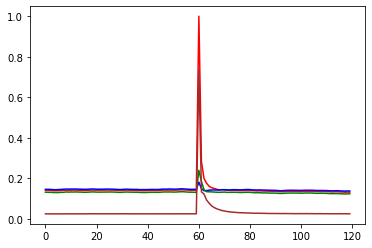

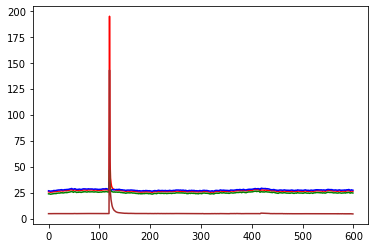

In [61]:
print( ' file name ' ,filenames[0])

print('IA_NONS,IB_NONS,IC_NONS')
import matplotlib.pyplot as plt
plt.plot(final_norm[5], linestyle = '-',color = 'r')#IA_NONS_SCLED
plt.plot(final_norm[6], linestyle = '-',color = 'b')#IB_NONS_SCLED
plt.plot(final_norm[7], linestyle = '-',color = 'g')#IC_NONS_SCLED
plt.plot(final_norm[8], linestyle = '-',color = 'brown')#IN
plt.show()

plt.plot(_all[3], linestyle = '-',color = 'r')#IA_NONS
plt.plot(_all[4], linestyle = '-',color = 'b')#IA_NONS
plt.plot(_all[5], linestyle = '-',color = 'g')#IA_NONS
plt.plot(_all[6], linestyle = '-',color = 'brown')#IA_NONS
# plt.plot(_all[42], linestyle = '-',color = 'brown')#iN
plt.show()


## Save to file in .npy

In [62]:
main_list_v1 = main_list
print(len(main_list_v1))

main_raw_v1= raw_RMS
print(len(main_raw_v1))

main_list_full_v1 = main_list_full
print(len(main_list_full_v1))

main_raw_full_v1= raw_RMS_full
print(len(main_raw_full_v1))

main_class_codes_v1= class_codes
print(len(main_class_codes_v1))

main_pos_codes_v1= pos_codes
print(len(main_pos_codes_v1))

main_phase_codes_v1= phase_codes
print(len(main_phase_codes_v1))

main_ground_codes_v1= ground_codes
print(len(main_ground_codes_v1))

main_f_name_v1= filenames
print(len(main_f_name_v1))

main_waveform_ids_v1= waveform_ids
print(len(main_waveform_ids_v1))

main_frequencies_v1= frequencies
print(len(main_frequencies_v1))

1
1
1
1
1
1
1
1
1
1
1


In [71]:
new_result

{0: [array([7442.1562, 7449.8594, 7448.08  , 7442.9814, 7448.2817, 7442.7485,
         7441.4443, 7448.463 , 7448.899 , 7443.4985, 7439.054 , 7450.6904,
         7439.1265, 7450.852 , 7446.4375, 7443.542 , 7449.6885, 7444.031 ,
         7441.8926, 7446.71  , 7446.7847, 7441.397 , 7447.9424, 7441.398 ,
         7448.5425, 7442.1284, 7438.628 , 7449.9536, 7447.8286, 7440.6436,
         7448.984 , 7440.38  , 7441.953 , 7447.2783, 7450.0884, 7441.087 ,
         7449.6655, 7440.6777, 7441.185 , 7447.077 , 7448.318 , 7443.729 ,
         7439.7607, 7448.148 , 7442.3926, 7447.489 , 7442.5273, 7447.801 ,
         7449.5947, 7443.163 , 7448.3115, 7444.1787, 7448.857 , 7444.036 ,
         7449.409 , 7442.2817, 7442.68  , 7447.942 , 7449.0186, 7441.416 ,
         7450.3564, 7443.4214, 7450.1245, 7442.522 , 7449.7607, 7442.107 ,
         7449.5107, 7443.425 , 7450.0454, 7443.409 , 7450.3306, 7445.605 ,
         7448.0254, 7441.97  , 7449.556 , 7447.9517, 7448.8945, 7449.6157,
         7448.653 , 74

In [ ]:
# Normalized X
x = np.dstack(main_list_v1)
x1 = x.T
x1.shape

In [ ]:
# RAW RMS X
x_raw = np.dstack(main_raw_v1)
x_raw1 = x_raw.T
x_raw1.shape

In [ ]:
y1 = np.array((#main_label_v1,
               main_class_codes_v1,
               main_pos_codes_v1,
               main_phase_codes_v1,
               main_ground_codes_v1,
               main_f_name_v1,
               main_waveform_ids_v1
              )).T
y1.shape

## Post procesing final visual check

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
plt.plot(x_raw1[3,:,12], linestyle = '-',color='r')
plt.plot(x_raw1[3,:,13], linestyle = '-',color='b')
plt.plot(x_raw1[3,:,14], linestyle = '-',color='g')
plt.show()

## Save or load file

In [ ]:
####### saving to numpy file
np.save("pos_code_7k_v1.npy", x1)
np.save("pos_code_7k_v1_raw.npy", x_raw1)
np.save("pos_code_7k_v1_label.npy",y1)

###### Loading the saved files
# saved_RMS = np.load("saved_RMS_v10.npy",allow_pickle=True)
# saved_RMS_label = np.load("saved_RMS_label_v10.npy",allow_pickle=True)